# Simulation of the 1945 Makran Tsunami

The 1945 Makran Tsunami was a large tsunami which originated due to the 1945 Balochistan earthquake. The resulting tsunami is beielved to have killed around 4000 people along the coast of modern day Pakistan, India, Iran and Oman. Tidal records indicate that the tsunami was recorded as far as the islands of Seychells and Minicoy. Moden simulations of the tsunami indicate tsunami elevations would have been observed across the islands of the Maldives as well. 

Here we will model the tsunami using elevations from actual fault estimations.

<img src="Map of Region.png" style="height:1000px, width:1000px">

As usual we begin by importing the required python libraries and modules. 

In [2]:
%matplotlib notebook
from thetis import*
import scipy.interpolate
import pyproj

Next we will import the mesh. Additionally we will visualise the mesh as well using the firedrake plot utility function. The plot function provides an easy way to plot of firedrake functions.    

<IPython.core.display.Javascript object>


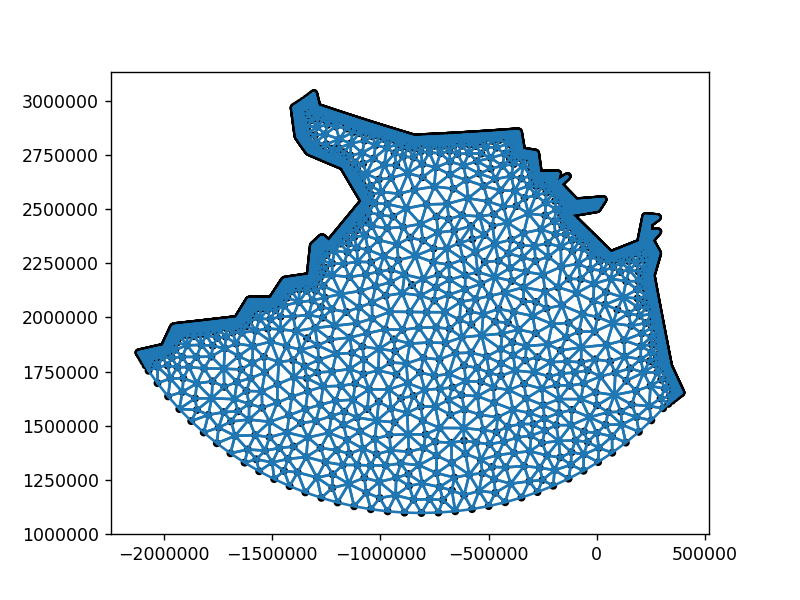

In [3]:
mesh = Mesh('Mesh/mesh.msh')
plot(mesh)

Next we will define the FunctionSpace. The functionspace is the place where our Functions will 'live'.

In [7]:
P1 = FunctionSpace(mesh, 'CG', 1)

Next we will define a bathymetry function. For the purpose of this simulation to keeps things simple we will assign a constant depth of 20m. Before creating the bathymetry function and assigning depth we will visualise the bathymetry of the area using GEBCO bathymetry dataset.              

<img src="Depth.png" style="height:1000px, width:1000px">

Now we will proceed with defining and assigning a depth using a bathymetry function, the bathymetry function will be defined within the FunctionSpace defined earlier. We will again visualise the depth to confirm if the value is assigned across the domain.

<IPython.core.display.Javascript object>


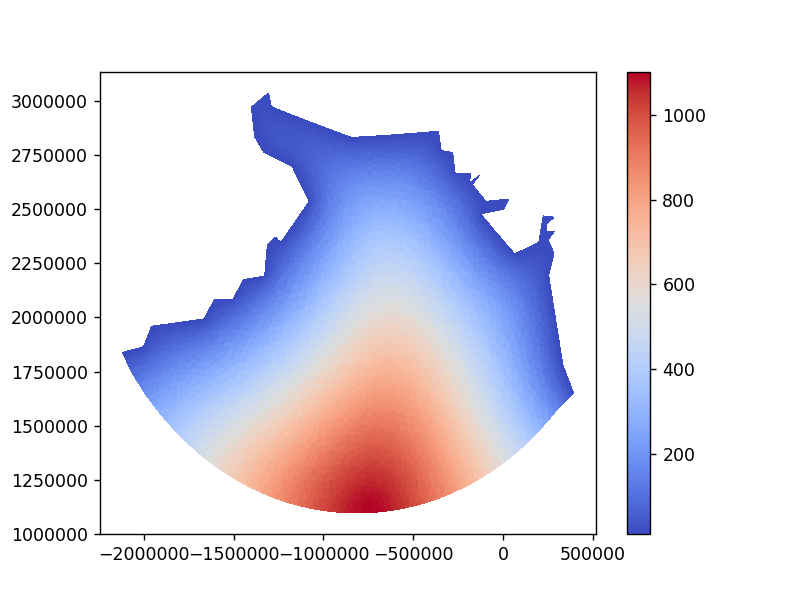

In [10]:
bathymetry_2d = Function(P1, name='Bathymetry')
with DumbCheckpoint('initialisation/bathy', mode=FILE_READ) as chk:
    chk.load(bathymetry_2d, name="bathy")


plot(bathymetry_2d)

Now we will define a function for the initial elevation, again in the same Functionspace. This initial elevation function will set the values for the initial elevation for our simulation. 

In [11]:
init_elev = Function(P1, name = 'init_elev')

After defining the initial elevation function we need to set the values of the function, across our mesh. We will do it in stages. First we will begin by accessing the co-ordinates of the mesh and the current values of the initial elevation function.

In [12]:
mesh_coordinates = mesh.coordinates.dat.data
init_elev_data = init_elev.dat.data

Next we will import the data that we wish to be interpolate onto the initial elevation function. Here the data that we wish to be interpolated on to our elevation function is the vertical displacement of the free-surface due to the earthquake. Given the earthquake fault parameters which is available from various sources such as USGS these deformations can be obtained through various means. Here we will use the output obtained from an 'Okada model' utilising single fault parameters as provided in Arjun.et.al. We will also take a look at the first row of the data, the columns are arranged as Longitude, Latitude, x, y and z dispalcement.

In [13]:
data = np.genfromtxt('outputs.txt')
#import numpy as np
#np.set_printoptions(suppress=True)
print (np.round(data[0],5))

[6.000e+01 1.500e+01 2.930e-03 1.914e-02 3.260e-03]


In order to interpolate the data values onto our mesh, we will use the scipy interpolator. First we create the interpolator. Note from above that the cordinates are given in the first two columns and the data values that we wish to interpolate (the surface elevations) are given in the fourth column.

In [14]:
intp = scipy.interpolate.NearestNDInterpolator(data[:,0:2], data[:,4])

Finally we are ready to interpolate. However since our mesh is in Universal Transverse Mercator coordinate system (UTM) coordinates and the data points are defined in World Geodetic System (WGS), we convert the data points to UTM, interpolate and set the value of the initial elevation function.

In [15]:
for i,xy in enumerate(mesh_coordinates):
    outproj = pyproj.Proj(init='epsg:4326')
    inproj = pyproj.Proj(init='epsg:32643') 
    lon, lat =pyproj.transform(inproj, outproj, xy[0], xy[1])
    init_elev_data[i] = intp(lon, lat)

If we wish to store the initial elevation as a hdf5 file wihch can be reloaded again, or wish to save the initial elevations as a pvd file which can be viewed. Additionally we will plot the initial elevation function to see if the values were set across the mesh.

<IPython.core.display.Javascript object>


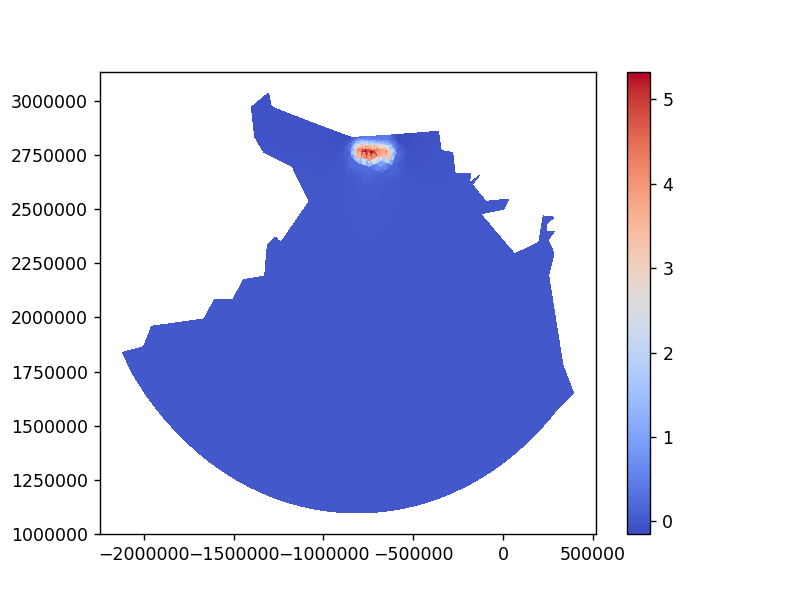

In [16]:
#To store as a hdf5 file, first define a dumbcheckpoint object and store the function.
#chk = DumbCheckpoint('init_elevation', mode=FILE_CREATE)
#chk.store(init_elev, name="init_elev")
#chk.close

# we save the values as a PVD file using a File object as below.(Note that the file suffix has to be .pvd. since firedrake saves in PVD format). 
#outfile = File("Initial_Elevation.pvd")
#outfile.write(init_elev)

#To plot the initial elevation function just call plot on the function as before.
plot (init_elev)

Now we define the total simulation time and the export times. The export time is when the simulation will export the stated parameters. 

In [17]:
# total duration in seconds
t_end = 3600.0*3
# export interval in seconds
t_export = 900.0

Now we are ready to create our solver and assign some options to run our model. We set the timesteppertype as CrankNicolson. We also define the timestep as 5 seconds.

In [18]:
solver_obj = solver2d.FlowSolver2d(mesh, bathymetry_2d)
options = solver_obj.options
#options.simulation_export_time = t_export
options.simulation_end_time = t_end
options.timestepper_type = 'CrankNicolson'
options.timestep = 5.0

Next we define the boundary conditions of our model. We will set the velocities at the coastlines and open boundaries to zero. The elevations at the open boudaries are also set to zero. 

In [19]:
solver_obj.bnd_functions['shallow_water'] = {
        100: {'un': 0.0},
        200: {'un': 0.0, 'elev' :0.0}
    }

Now we are ready to set the initial conditions of our simulation. We set the initial elevations of our simulation to the initial elevation function we created earlier. Additionally as we wish to visualise the simulation as it goes on we will define a function that will plot the elevation at certain time steps.

In [20]:
def update_forcings(t_new):
    uv, elev = solver_obj.fields.solution_2d.split()
    plot_time = [0,2000,4000,6000,8000,10000]
    for i in plot_time:
        if t_new == i:
            plot(elev)

solver_obj.assign_initial_conditions(elev=init_elev)

dt = 5.0
Using time integrator: CrankNicolson


Now set the solver iterator to start the simulation running.

    0     0 T=      0.00 eta norm: 477519.7838 u norm:     0.0000  0.00
    1    20 T=    100.00 eta norm: 476045.2960 u norm: 13274.2501 12.22
    2    40 T=    200.00 eta norm: 471870.4162 u norm: 25689.1114  9.67
    3    60 T=    300.00 eta norm: 465409.6475 u norm: 37340.8646  9.61
    4    80 T=    400.00 eta norm: 457099.4944 u norm: 48261.5402  9.44
    5   100 T=    500.00 eta norm: 447374.4957 u norm: 58457.1589  9.48
    6   120 T=    600.00 eta norm: 436651.8943 u norm: 67927.7878  9.98
    7   140 T=    700.00 eta norm: 425319.1685 u norm: 76677.0619  9.47
    8   160 T=    800.00 eta norm: 413724.0422 u norm: 84716.0249  9.50
    9   180 T=    900.00 eta norm: 402167.4627 u norm: 92064.2883  9.38
   10   200 T=   1000.00 eta norm: 390899.8962 u norm: 98749.7370  9.39
   11   220 T=   1100.00 eta norm: 380120.9186 u norm: 104807.1291  9.84
   12   240 T=   1200.00 eta norm: 369981.5309 u norm: 110276.2227  9.31
   13   260 T=   1300.00 eta norm: 360588.2737 u norm: 115200.

<IPython.core.display.Javascript object>


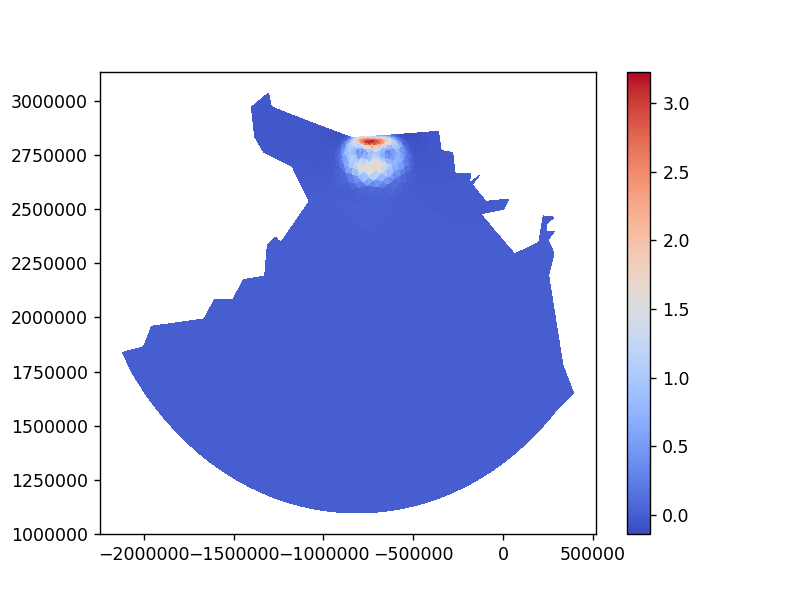

   20   400 T=   2000.00 eta norm: 317733.3660 u norm: 138096.0375 12.03
   21   420 T=   2100.00 eta norm: 314533.3841 u norm: 140125.6108  9.50
   22   440 T=   2200.00 eta norm: 311908.2451 u norm: 141881.9222  9.31
   23   460 T=   2300.00 eta norm: 309811.2204 u norm: 143347.4215 10.08
   24   480 T=   2400.00 eta norm: 308206.2857 u norm: 144492.2681  9.39
   25   500 T=   2500.00 eta norm: 307070.2757 u norm: 145274.9325  9.45
   26   520 T=   2600.00 eta norm: 306393.3402 u norm: 145643.9245  9.66
   27   540 T=   2700.00 eta norm: 306176.5842 u norm: 145542.1172  9.50
   28   560 T=   2800.00 eta norm: 306425.8999 u norm: 144914.8961  9.94
   29   580 T=   2900.00 eta norm: 307142.0429 u norm: 143722.2093  9.44
   30   600 T=   3000.00 eta norm: 308308.6580 u norm: 141952.8737  9.89
   31   620 T=   3100.00 eta norm: 309881.5209 u norm: 139638.1515  9.38
   32   640 T=   3200.00 eta norm: 311782.4306 u norm: 136861.7359  9.41
   33   660 T=   3300.00 eta norm: 313899.6025 u no

<IPython.core.display.Javascript object>


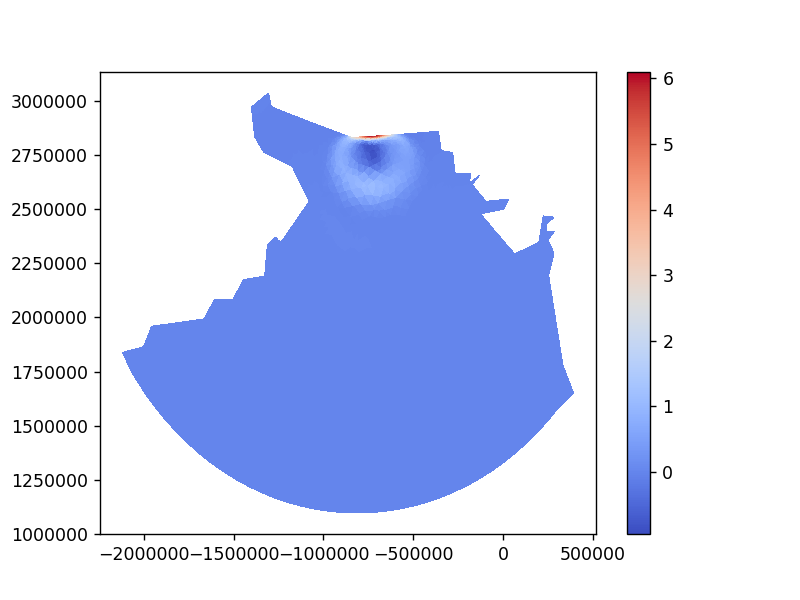

   40   800 T=   4000.00 eta norm: 322374.2787 u norm: 123000.7149 13.25
   41   820 T=   4100.00 eta norm: 321128.2657 u norm: 125611.4253  9.39
   42   840 T=   4200.00 eta norm: 319047.8378 u norm: 129423.0933  9.64
   43   860 T=   4300.00 eta norm: 316130.5254 u norm: 134272.2826  9.50
   44   880 T=   4400.00 eta norm: 312403.3147 u norm: 139943.4162  9.52
   45   900 T=   4500.00 eta norm: 307922.8850 u norm: 146197.7983  9.73
   46   920 T=   4600.00 eta norm: 302775.1331 u norm: 152797.4086  9.31
   47   940 T=   4700.00 eta norm: 297073.1100 u norm: 159521.3414  9.42
   48   960 T=   4800.00 eta norm: 290952.9483 u norm: 166175.3585  9.64
   49   980 T=   4900.00 eta norm: 284568.0133 u norm: 172595.9853  9.38
   50  1000 T=   5000.00 eta norm: 278082.0441 u norm: 178650.8774  9.66
   51  1020 T=   5100.00 eta norm: 271662.2174 u norm: 184236.9397  9.42
   52  1040 T=   5200.00 eta norm: 265472.8437 u norm: 189277.3037  9.98
   53  1060 T=   5300.00 eta norm: 259669.9727 u no

<IPython.core.display.Javascript object>


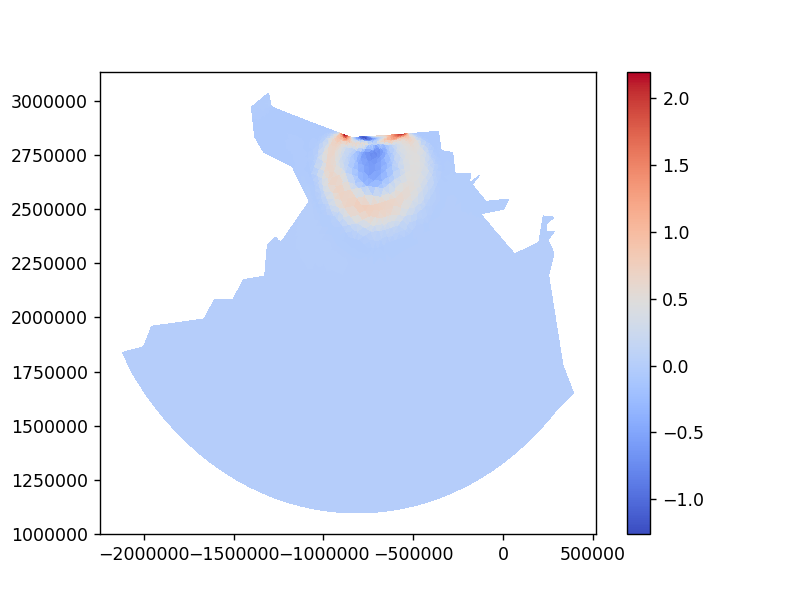

   60  1200 T=   6000.00 eta norm: 239200.2160 u norm: 206779.9517 13.23
   61  1220 T=   6100.00 eta norm: 239702.1099 u norm: 206209.3551 12.38
   62  1240 T=   6200.00 eta norm: 240977.8276 u norm: 205112.0170 10.88
   63  1260 T=   6300.00 eta norm: 242941.9580 u norm: 203523.5231 10.86
   64  1280 T=   6400.00 eta norm: 245500.6402 u norm: 201480.3651 11.42
   65  1300 T=   6500.00 eta norm: 248558.9519 u norm: 199019.2811 10.78
   66  1320 T=   6600.00 eta norm: 252026.6975 u norm: 196176.7951 10.30
   67  1340 T=   6700.00 eta norm: 255822.0754 u norm: 192988.9482 10.42
   68  1360 T=   6800.00 eta norm: 259873.1753 u norm: 189491.2068 10.20
   69  1380 T=   6900.00 eta norm: 264117.6377 u norm: 185718.5259 10.31
   70  1400 T=   7000.00 eta norm: 268501.0551 u norm: 181705.5451 11.16
   71  1420 T=   7100.00 eta norm: 272974.7867 u norm: 177486.8730 11.27
   72  1440 T=   7200.00 eta norm: 277493.8214 u norm: 173097.4060 11.52
   73  1460 T=   7300.00 eta norm: 282015.1834 u no

<IPython.core.display.Javascript object>


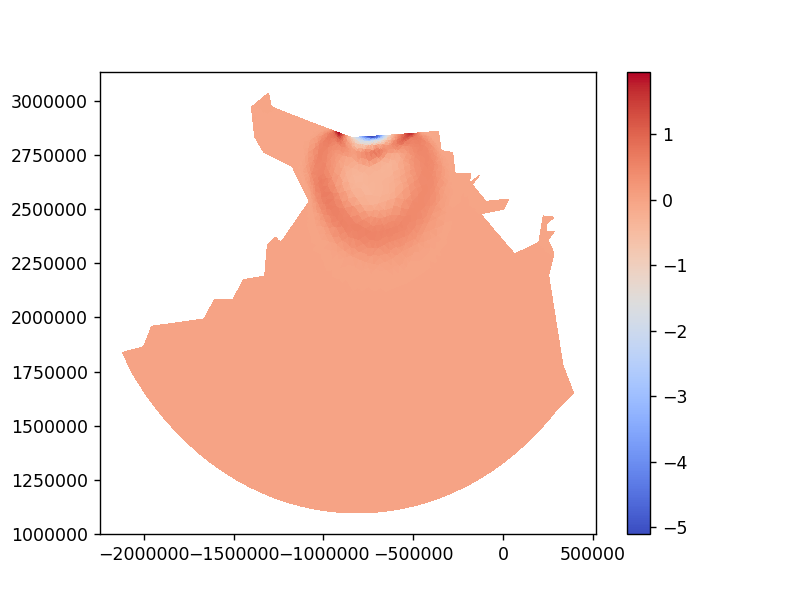

   80  1600 T=   8000.00 eta norm: 310523.6387 u norm: 136289.8388 13.98
   81  1620 T=   8100.00 eta norm: 313803.6714 u norm: 132079.7604 11.34
   82  1640 T=   8200.00 eta norm: 316840.5033 u norm: 128103.3030 13.47
   83  1660 T=   8300.00 eta norm: 319632.4892 u norm: 124409.6098 11.31
   84  1680 T=   8400.00 eta norm: 322181.3468 u norm: 121049.7085 11.06
   85  1700 T=   8500.00 eta norm: 324490.8907 u norm: 118075.6310 10.64
   86  1720 T=   8600.00 eta norm: 326565.9311 u norm: 115538.8527 12.27
   87  1740 T=   8700.00 eta norm: 328411.4676 u norm: 113487.7998 11.89
   88  1760 T=   8800.00 eta norm: 330032.2263 u norm: 111964.5235  9.75
   89  1780 T=   8900.00 eta norm: 331432.5603 u norm: 111000.8467 12.45
   90  1800 T=   9000.00 eta norm: 332616.6127 u norm: 110614.7564 10.58
   91  1820 T=   9100.00 eta norm: 333588.6964 u norm: 110807.0602 10.98
   92  1840 T=   9200.00 eta norm: 334353.8660 u norm: 111558.8393 10.83
   93  1860 T=   9300.00 eta norm: 334918.6453 u no

<IPython.core.display.Javascript object>


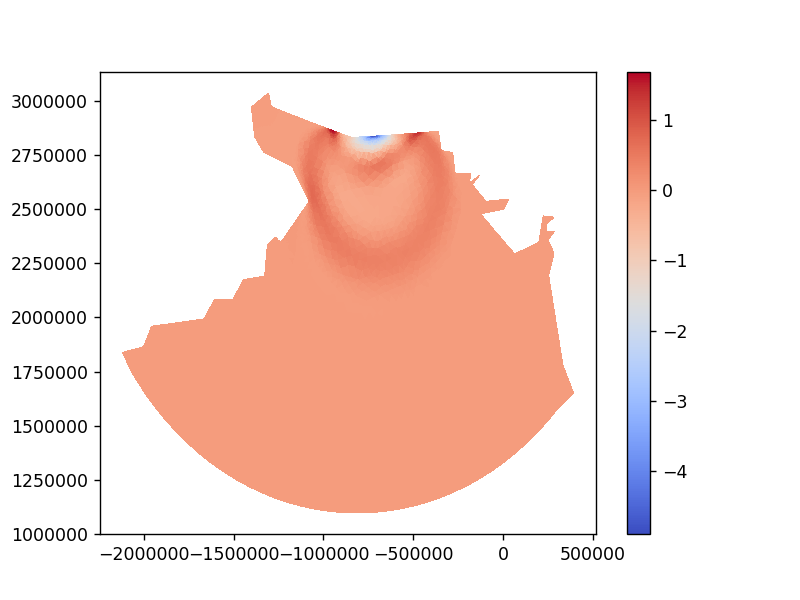

  100  2000 T=  10000.00 eta norm: 334474.2520 u norm: 128404.1744 13.64
  101  2020 T=  10100.00 eta norm: 334039.3960 u norm: 130260.9705 12.02
  102  2040 T=  10200.00 eta norm: 333560.2533 u norm: 131917.8513 11.44
  103  2060 T=  10300.00 eta norm: 333037.8401 u norm: 133414.2776 10.27
  104  2080 T=  10400.00 eta norm: 332469.8078 u norm: 134776.1781 11.34
  105  2100 T=  10500.00 eta norm: 331856.0643 u norm: 136009.8433 12.17
  106  2120 T=  10600.00 eta norm: 331202.1227 u norm: 137115.3572 10.80
  107  2140 T=  10700.00 eta norm: 330514.7779 u norm: 138090.5021 10.55
  108  2160 T=  10800.00 eta norm: 329800.8279 u norm: 138923.2451 11.55


In [21]:
%timeit
solver_obj.iterate(update_forcings=update_forcings)